# Tail Risk and Short-Term Capital Management

## FINM 36700: Portfolio and Risk Management

### UChicago Financial Mathematics

#### Autumn 2024

Questions?
* Contact: Mark Hendricks
* hendricks@uchicago.edu

### Note:

To run this notebook, skip the first cells describing the puzzle.

## A Puzzle

Suppose we are examining a fund, Short-Term Capital Management, (STCM). We see the following:

In [17]:
stcm_returns.loc[['mean','std','sharpe_ratio'],['Conditional']].style.format('{:,.2%}')

,Conditional
mean,26.27%
std,14.71%
sharpe_ratio,178.61%


Seems like a great strategy right? Well, let's look at the higher moments.

In [18]:
stcm_returns[['Conditional']].style.format('{:,.2%}')

,Conditional
mean,26.27%
std,14.71%
sharpe_ratio,178.61%
skewness,-846.99%
excess_kurtosis,"8,099.82%"


What is going on here? Is this still a good strategy?
* Notwithstanding the substantial negative skewness, the Sharpe (mean-versus-vol) is very good.
* Does VaR or CVaR reveal anything?

In [19]:
rstcm_cond = STCM_Performance[STCM_Performance['Fund Bust'] == 0]['Gross Returns'].astype('float')

tab = pd.DataFrame(index = ['VaR (.01)','CVaR (.01)','VaR-to-vol'], columns=['Conditional'],dtype=float)
tab.loc['VaR (.01)'] = rstcm_cond.quantile(.01)
tab.loc['CVaR (.01)'] = rstcm_cond[rstcm_cond<rstcm_cond.quantile(.01)].mean()
tab.loc['VaR-to-vol'] = rstcm_cond.quantile(.01) / rstcm_cond.std()
tab.style.format('{:.2%}')

,Conditional
VaR (.01),-16.68%
CVaR (.01),-31.57%
VaR-to-vol,-392.83%


***

# The Strategy

Their strategy is simple: **each month they sell out-of-the-money put options.** 

They invest the fund’s assets along with the proceeds from selling the puts into riskless treasuries. One month later, the assets have grown by the riskless rate, and they buy back the put options to cover last month’s position. They then repeat the process by selling fresh put options and investing everything back in the riskless rate.

In [1]:
# import libraries
import math
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 2)
sns.set(rc={'figure.figsize':(14, 6)})


def BSMPricer(S, K, vol, T, rf):
    d1 = (np.log(S/K) + (rf + (vol**2)/2)*T)/(np.sqrt(T)*vol)
    d2 = d1 - (np.sqrt(T)*vol)
    price = norm.cdf(-d2)*K*np.exp(-rf*T) - norm.cdf(-d1)*S
    return price


def tradingStrategy(Wt, Pt, Pt1, sigma, rate):
    put_price = BSMPricer(Pt, 0.8*Pt, sigma, 2, rate)
    nt = 0.03*Wt/put_price
    Lt1 = nt*BSMPricer(Pt1, 0.8*Pt, sigma, 1, rate)
    Wt1_bar = 1.03*Wt*(1 + rate) - Lt1
    gross_return = (Wt1_bar/Wt - 1) - rate
    fee = max(0.02*Wt/12, 0) + max(0.2*Wt*gross_return, 0)
    Wt1 = Wt1_bar - fee
    if Wt1 < 0:
        bust = 1
    else:
        bust = 0
    return [Wt1, Wt1_bar, gross_return, fee, bust]

In [2]:
# Constant monthly risk free rate
rf = 0.002

# Constant implied vol
vol = 0.05

# Fund Starting Value
W = 50000000

In [3]:
SHEET = 'total returns'
spy = pd.read_excel('../data/spy_data.xlsx', sheet_name=SHEET).set_index('date')[['SPY']]#.rename(columns={'SPY':'rets'})

### resample to monthly
def cumulative_returns(r):
    return (1 + r).prod() - 1

spy = spy.resample('M').apply(cumulative_returns)

In [4]:
spy['Price'] = (1 + spy['SPY']).cumprod()

In [5]:
STCM_Performance = pd.DataFrame(index = spy.index, columns = ['Net Assets', 'Gross Assets', 'Gross Returns', 'Management Fee', 'Fund Bust'])

dates = list(STCM_Performance.index)
STCM_Performance.iloc[0] = [W,W,0,0,0]

for i in range(1, len(dates)):
    today, yesterday = dates[i], dates[i-1]
    STCM_Performance.loc[today] = tradingStrategy(STCM_Performance['Net Assets'].loc[yesterday], spy['Price'].loc[yesterday], spy['Price'].loc[today], vol, rf)
    if STCM_Performance.loc[today]['Fund Bust'] == 1:
        STCM_Performance.loc[today][['Gross Assets', 'Net Assets']] = [W, W]

fund_bust_dates = STCM_Performance['Fund Bust'][STCM_Performance['Fund Bust'] == 1].to_frame('Fund Bust')

# Assets: Boom and Bust

In [6]:
display(STCM_Performance.head(5))
display(STCM_Performance.tail(5))

,Net Assets,Gross Assets,Gross Returns,Management Fee,Fund Bust
date,,,,,
1994-01-31,50000000,50000000,0,0,0
1994-02-28,51169084.47,51540522.25,0.03,371437.78,0
1994-03-31,52261321.26,52615398.17,0.03,354076.91,0
1994-04-30,53534389.59,53935403.76,0.03,401014.17,0
1994-05-31,54838910.06,55249802.96,0.03,410892.9,0


,Net Assets,Gross Assets,Gross Returns,Management Fee,Fund Bust
date,,,,,
2024-04-30,102883342.9,103589797.8,0.03,706454.9,0
2024-05-31,105391740.98,106181739.13,0.03,789998.15,0
2024-06-30,107961143.48,108770364.37,0.03,809220.88,0
2024-07-31,110591242.58,111419705.83,0.03,828463.25,0
2024-08-31,113138824.03,113950822.19,0.03,811998.16,0


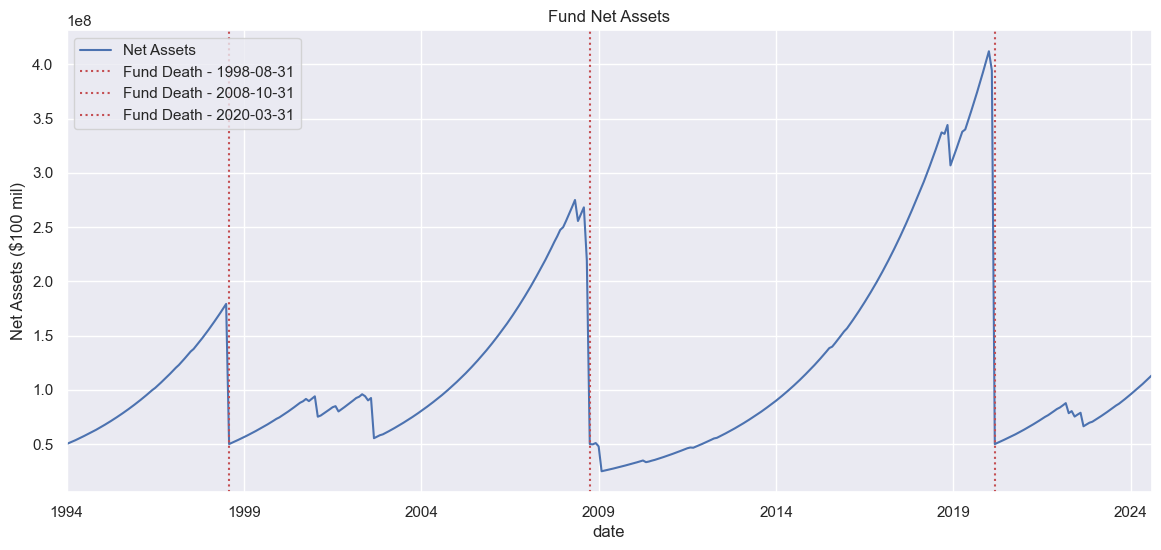

In [7]:
STCM_Performance['Net Assets'].plot()
for i in fund_bust_dates.index:
    plt.axvline(i, linestyle = 'dotted', color = 'r', label = 'Fund Death - ' + str(i.date()))

plt.title('Fund Net Assets')
plt.ylabel('Net Assets ($100 mil)')
plt.legend()
plt.show()

In [8]:
display(fund_bust_dates)

,Fund Bust
date,
1998-08-31,1
2008-10-31,1
2020-03-31,1


In [9]:
fund_1 = STCM_Performance.loc[:str(fund_bust_dates.index[0])]
fund_2 = STCM_Performance.loc[str(fund_bust_dates.index[0]):str(fund_bust_dates.index[1])].iloc[1:]
fund_3 = STCM_Performance.loc[str(fund_bust_dates.index[1]):str(fund_bust_dates.index[2])].iloc[1:]
fund_4 = STCM_Performance.loc[str(fund_bust_dates.index[2]):].iloc[1:]

In [10]:
funds = pd.DataFrame(index = ['Fund 1', 'Fund 2', 'Fund 3', 'Fund 4'], columns = ['Lifespan', 'Max Net Assets ($ mil)'])

funds['Lifespan'] = [str(fund_1.index.date[0]) + ' - ' + str(fund_1.index.date[len(fund_1)-1]),
                    str(fund_2.index.date[0]) + ' - ' + str(fund_2.index.date[len(fund_2)-1]),
                    str(fund_3.index.date[0]) + ' - ' + str(fund_3.index.date[len(fund_3)-1]),
                    str(fund_4.index.date[0]) + ' - ' + str(fund_4.index.date[len(fund_4)-1])]

funds['Max Net Assets ($ mil)'] = [max(fund_1['Net Assets']), max(fund_2['Net Assets']), max(fund_3['Net Assets']), max(fund_4['Net Assets'])]

funds['Max Net Assets ($ mil)'] = funds['Max Net Assets ($ mil)']/1000000

display(funds)

,Lifespan,Max Net Assets ($ mil)
Fund 1,1994-01-31 - 1998-08-31,179.21
Fund 2,1998-09-30 - 2008-10-31,275.02
Fund 3,2008-11-30 - 2020-03-31,412.15
Fund 4,2020-04-30 - 2024-08-31,113.14


In [11]:
print('Maximum value of net assets is ${:,.2f} million. This high water mark is observed on {}'.
      format(max(STCM_Performance['Net Assets'])/1000000, 
              STCM_Performance[STCM_Performance['Net Assets'] == max(STCM_Performance['Net Assets'])].index.date[0]))

Maximum value of net assets is $412.15 million. This high water mark is observed on 2020-01-31


# Performance Metrics

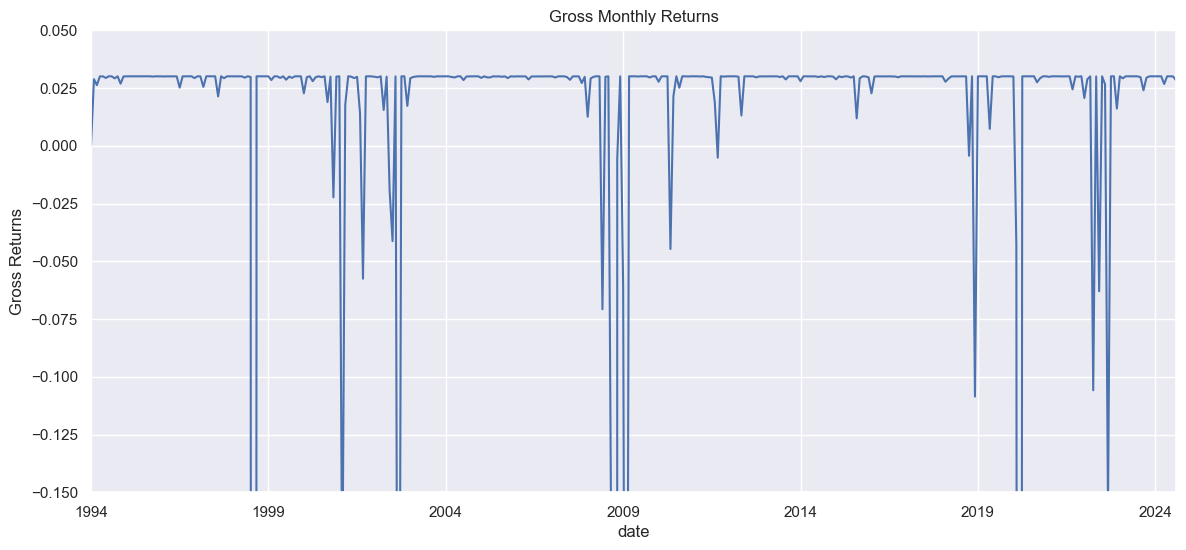

In [12]:
STCM_Performance['Gross Returns'].plot()
plt.title('Gross Monthly Returns')
plt.ylabel('Gross Returns')
plt.ylim(-.15, 0.05)
plt.show()

### Good-Times Stats

For the conditional stats, the mean is quite high and the Sharpe ratio is fantastic. However, the returns are very negatively skewed and massively kurtotic. Thus, even conditional on surviving it is clear the fund has substantial nonlinear risk.

### Full-Sample Stats
As seen in Table above, the return stats change enormously. The mean return is now negative and the volatility is massive. Furthermore, the skewness and kurtosis were already extreme but now even more so.

In [13]:
def getPerformanceMetrics(data):

    data_desc = data.describe().loc[['mean','std']]

    data_desc.loc['mean'] = data_desc.loc['mean']*12 # annualize
    data_desc.loc['std'] = data_desc.loc['std']*np.sqrt(12) # annualize
    data_desc.loc['sharpe_ratio'] = data_desc.loc['mean'] / data_desc.loc['std']
    
    data_desc.loc['skewness'] = data.skew()
    data_desc.loc['excess_kurtosis'] = data.kurt()-3
    
    return data_desc

In [14]:
stcm_returns = getPerformanceMetrics(STCM_Performance[STCM_Performance['Fund Bust'] == 0]['Gross Returns'].astype('float')).to_frame('Conditional')
stcm_returns['Unconditional'] = getPerformanceMetrics(STCM_Performance['Gross Returns'].astype('float'))
display(stcm_returns.style.format('{:,.2%}'))

,Conditional,Unconditional
mean,26.27%,-26.55%
std,14.71%,213.62%
sharpe_ratio,178.61%,-12.43%
skewness,-846.99%,"-1,663.39%"
excess_kurtosis,"8,099.82%","29,043.43%"


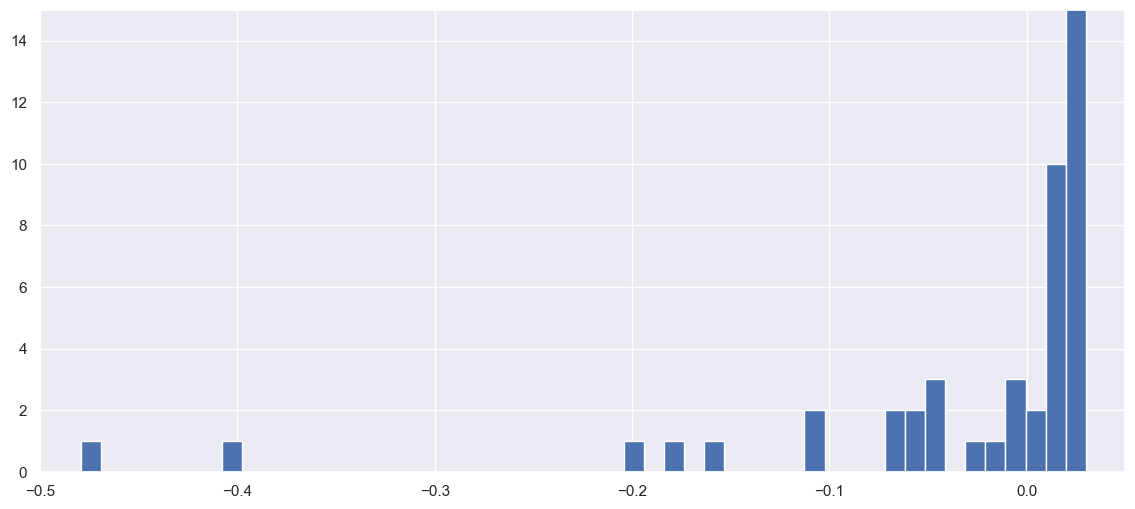

In [15]:
ax = STCM_Performance[STCM_Performance['Fund Bust'] == 0]['Gross Returns'].astype('float').hist(bins=50)
ax.set_ylim([0,15]);
ax.set_xlim([-.5,.05]);

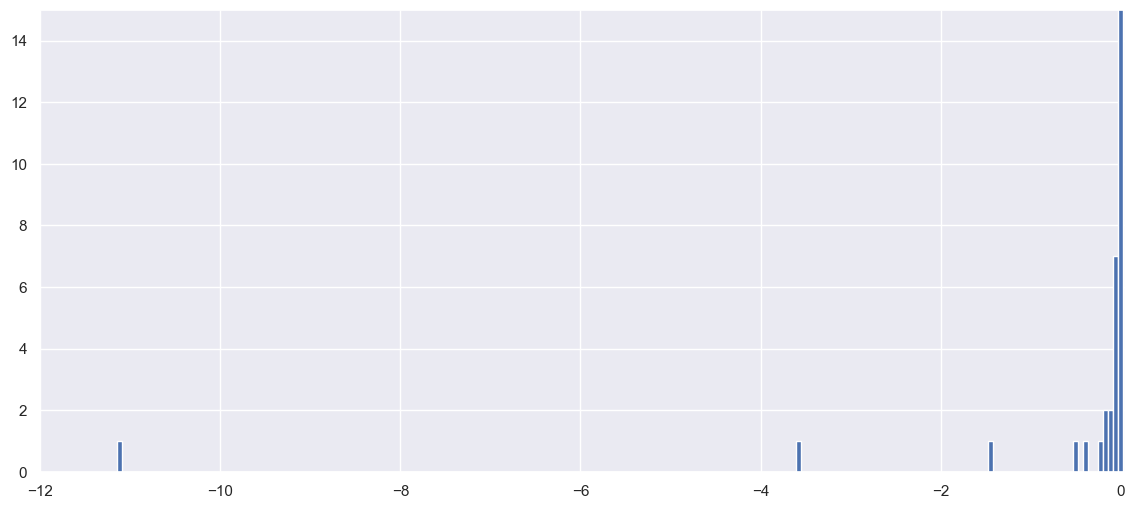

In [16]:
ax = STCM_Performance['Gross Returns'].astype('float').hist(bins=200)
ax.set_ylim([0,15]);
ax.set_xlim([-12,0.05]);

Investors in nonlinear strategies need to be very careful that they evaluate the fund performance on a large enough data sample so as to see the true distribution of the returns.

***

# Appendix

Use the following data to test the strategy:
- Use the market index data in the **“S&P500”** tab.

- Assume a constant monthly riskless rate of $r_f$ = 0.0020.

- Assume a constant implied volatility of $\sigma$ = 0.05.

- Test the strategy assuming the fund begins with assets of $W_0$ = $50, 000, 000.

<ins>The details of the strategy are as follows:</ins>


- At the end of the first month, we sell puts with maturity $\tau = 2$ and strike price of $K = 0.80S$, where $S$ is the current market price, $P^m_t$


- Calculate the price you receive on the puts using the Black-Scholes formulas:

$$
put = f_p(S,K,\sigma, \tau, r_f) = \mathcal{N}(-d_2)*K*e^{-r_f \tau} - S*\mathcal{N}(-d_1)
$$

$$
d_1 = \frac{log\frac{S}{K} + (r_f + \frac{\sigma^2}{2})\tau}{\sigma\sqrt{\tau}}
$$

$$
d_2 = d_1 - \sigma\sqrt{\tau}
$$

where, $r_f$ is the constant riskless rate given above, $\sigma$ is the constant implied volatility given above, and $\mathcal{N}(·)$ is the standard normal cumulative distribution.



- We sell $n_t$ of these put options, where $n_t$ is calculated such that the premium we receive equals 3% of the fund’s total assets, $W_t$,

$$
n_t = \frac{0.03}{f_p(P^m_t,0.8P^m_t,\sigma, \tau, r_f)} * W_t
$$


- Thus the dollars received, $G_t$, from selling this number of puts will immediately increase the fund’s assets by 3%.

$$
G_t = n_t * \frac{0.03}{f_p(P^m_t,0.8P^m_t,\sigma, \tau, r_f)} = 0.03W_t
$$



- At the end of the following month, t + 1, we must use Lt+1 in assets to cover the puts from last month buy purchasing puts with $\tau = 1$ and $K = .80P^m_t$. We use the Black-Scholes formula above to calculate this amount:

$$
L_{t+1} = n_t * f_p(P^m_{t+1},0.8P^m_t,\sigma, 1, r_f)
$$


- Calculate the fund’s gross (before-fees) assets, $\tilde{W}$, at time $t + 1$ after covering the puts:

$$
\tilde{W}_{t+1} = (W_t + G_t)(1+r_f) - L_{t+1} = (W_t + 0.03W_t)(1+r_f) - L_{t+1}
$$

where the first term is the past month’s assets plus the 3% jump from issuing puts at the last month, all invested at the riskless rate until the end of this month, at which point we cover the position

-  Calculate the fund’s gross (before fees) excess return from $t$ to $t + 1$:

$$
R^{\#stcm}_{t+1} = \frac{\tilde{W}_{t+1} - W_t}{W_t} - r_f
$$

-  Calculate the management compensation at time $t$ as follows:

$$
\pi_{t+1} = max(\frac{0.02}{12}*W_t, 0) + max(0.2W_t * R^{\#stcm}_{t+1}, 0)
$$

-  Get the fund’s net capital by subtracting the managerial fee:

$$
W_{t+1} = \tilde{W}_{t+1} - \pi_{t+1}
$$

- Let $B_t$ be a true/false variable indicating whether the fund has gone bust. If $W_t < 0$, then assume the fund immediately re-opens with the initial asset level of $W_0$ = $50 million

-  Finally, still at the end of month $t + 1$, we repeat the whole process by selling $n_{t+1}$ put options, so as to make the fund’s net assets jump 3% immediately

-  Thus, equations above give a recursion for building a timeseries of the funds net assets, $W_{t}$, the managerial compensation, $\pi_{t}$, and the fund’s gross excess returns, $R^{\#stcm}_{t}$